In [173]:
import pandas as pd
import numpy as np
import os
import re
import multiprocessing as mp
import logging
import matplotlib.pyplot as plt 
pd.set_option('display.max_columns', 700)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all columns
pd.set_option('display.float_format', '{:.5f}'.format)

In [174]:
df = pd.read_csv("../../data/TUMTUMTUM/long_df.csv")
df.head()

,coin,date,RET,close,target,high,low,open,volume,EventID
0,AAVEUSDT,2025-01-01 00:00:00,0.01591,313.61000,0,313.72000,308.72000,308.73000,27473.90000,0
1,AAVEUSDT,2025-01-01 01:00:00,-0.00077,313.37000,0,314.28000,311.37000,313.61000,23172.20000,0
2,AAVEUSDT,2025-01-01 02:00:00,0.00377,314.55000,0,316.92000,313.21000,313.37000,26176.50000,0
3,AAVEUSDT,2025-01-01 03:00:00,-0.00741,312.22000,1,314.58000,311.81000,314.53000,13005.10000,1
4,AAVEUSDT,2025-01-01 04:00:00,-0.00746,309.89000,1,313.19000,309.72000,312.20000,17516.70000,1


In [175]:
df['close_zscore'] = (
    df.groupby('coin')['close']
    .transform(lambda x: (x - x.mean()) / x.std())
)
df.head()

,coin,date,RET,close,target,high,low,open,volume,EventID,close_zscore
0,AAVEUSDT,2025-01-01 00:00:00,0.01591,313.61000,0,313.72000,308.72000,308.73000,27473.90000,0,1.01041
1,AAVEUSDT,2025-01-01 01:00:00,-0.00077,313.37000,0,314.28000,311.37000,313.61000,23172.20000,0,1.00631
2,AAVEUSDT,2025-01-01 02:00:00,0.00377,314.55000,0,316.92000,313.21000,313.37000,26176.50000,0,1.02647
3,AAVEUSDT,2025-01-01 03:00:00,-0.00741,312.22000,1,314.58000,311.81000,314.53000,13005.10000,1,0.98666
4,AAVEUSDT,2025-01-01 04:00:00,-0.00746,309.89000,1,313.19000,309.72000,312.20000,17516.70000,1,0.94684


In [176]:
# Shift target by 5 steps forward within each coin group
df["target"] = (
    df.groupby("coin")["target"]
      .shift(-10)  # negative shift = look 5 steps ahead
)

# Drop rows where future target is NaN (end of each coin)
df = df.dropna(subset=["target"]).reset_index(drop=True)

df.head()

,coin,date,RET,close,target,high,low,open,volume,EventID,close_zscore
0,AAVEUSDT,2025-01-01 00:00:00,0.01591,313.61000,1.00000,313.72000,308.72000,308.73000,27473.90000,0,1.01041
1,AAVEUSDT,2025-01-01 01:00:00,-0.00077,313.37000,1.00000,314.28000,311.37000,313.61000,23172.20000,0,1.00631
2,AAVEUSDT,2025-01-01 02:00:00,0.00377,314.55000,1.00000,316.92000,313.21000,313.37000,26176.50000,0,1.02647
3,AAVEUSDT,2025-01-01 03:00:00,-0.00741,312.22000,0.00000,314.58000,311.81000,314.53000,13005.10000,1,0.98666
4,AAVEUSDT,2025-01-01 04:00:00,-0.00746,309.89000,0.00000,313.19000,309.72000,312.20000,17516.70000,1,0.94684


In [177]:
import pandas as pd

def add_zscore_mas(df: pd.DataFrame, windows: list[int], field: str = "close_zscore") -> pd.DataFrame:
    """
    Add moving average columns of <field> (default: close_zscore) for each coin.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing at least ['coin', field].
    windows : list[int]
        List of window sizes for which to compute moving averages.
    field : str
        The field to smooth (default 'close_zscore').

    Returns
    -------
    pd.DataFrame
        Copy of df with added columns:
        '<field>_MA{window}' for each window in windows.
    """
    out = df.copy()

    for w in windows:
        ma_col = f"{field}_MA{w}"
        out[ma_col] = (
            out.groupby("coin")[field]
            .transform(lambda x: x.rolling(window=w).mean())
        )

    return out

df = add_zscore_mas(df, windows=[2, 6, 12, 24, 3*24, 5*24, 7*24])

In [178]:
def add_rsi_for_zscore(df: pd.DataFrame, windows: list[int], field: str = "close_zscore") -> pd.DataFrame:
    """
    Add RSI columns (using Wilder's smoothing) for <field> per coin.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing at least ['coin', field].
    windows : list[int]
        List of window sizes for which to compute RSI.
    field : str
        Column to compute RSI on (default: 'close_zscore').

    Returns
    -------
    pd.DataFrame
        Copy of df with new columns '<field>_RSI{window}' for each window.
    """
    out = df.copy()

    for w in windows:
        rsi_col = f"{field}_RSI{w}"

        def _rsi(series):
            d = series.diff()
            gain = d.clip(lower=0)
            loss = -d.clip(upper=0)

            avg_gain = gain.ewm(com=w - 1, min_periods=w, adjust=False).mean()
            avg_loss = loss.ewm(com=w - 1, min_periods=w, adjust=False).mean()

            rs = avg_gain / avg_loss.replace(0, np.nan)
            rsi = 100 - (100 / (1 + rs))

            # Handle edge cases
            both_zero = (avg_gain == 0) & (avg_loss == 0)
            rsi = rsi.where(~both_zero, 50)
            return rsi

        out[rsi_col] = out.groupby("coin")[field].transform(_rsi)

    return out

df = add_rsi_for_zscore(df, windows=[2, 6, 12, 24, 24*2, 24*3])

In [179]:
import numpy as np
import pandas as pd

def add_volume_rsi_long(
    df: pd.DataFrame,
    windows: list[int],
    coin_col: str = "coin",
    open_col: str = "open",
    close_col: str = "close",
    volume_col: str = "volume",
    date_col: str = "date",
    fill_initial_with_50: bool = False,
) -> pd.DataFrame:
    """
    Add Volume RSI (VRSI) columns for each window in `windows` to a long-format DF.

    VRSI is RSI computed on:
        vol_delta = sign(close - open) * volume

    Wilder smoothing: EWMA with com = window-1
    Output columns: VRSI{window}
    """
    out = df.copy()

    # ensure proper ordering for EWMs
    if date_col in out.columns:
        out = out.sort_values([coin_col, date_col])

    # ensure numeric
    out[open_col]   = pd.to_numeric(out[open_col], errors="coerce")
    out[close_col]  = pd.to_numeric(out[close_col], errors="coerce")
    out[volume_col] = pd.to_numeric(out[volume_col], errors="coerce")

    # unique, sorted windows
    win_list = sorted(set(int(w) for w in windows))

    for w in win_list:
        def _vrsi(group: pd.DataFrame) -> pd.Series:
            vol_delta = np.sign(group[close_col] - group[open_col]) * group[volume_col]
            gain = vol_delta.clip(lower=0.0)
            loss = (-vol_delta).clip(lower=0.0)

            avg_gain = gain.ewm(com=w-1, adjust=False, min_periods=w).mean()
            avg_loss = loss.ewm(com=w-1, adjust=False, min_periods=w).mean()

            rs = avg_gain / avg_loss.replace(0, np.nan)
            vrsi = 100 - (100 / (1 + rs))
            if fill_initial_with_50:
                # when both avg_gain and avg_loss are zero initially, set RSI=50
                both_zero = (avg_gain == 0) & (avg_loss == 0)
                vrsi = vrsi.where(~both_zero, 50)
            return vrsi

        out[f"VRSI{w}"] = (
            out.groupby(coin_col, group_keys=False, include_groups=False)
               .apply(_vrsi)
        )

    return out


df = add_volume_rsi_long(
    df,
    windows=[2, 6, 12, 24, 48, 72],  # 24*2=48, 24*3=72
    fill_initial_with_50=True
)

# quick check
[col for col in df.columns if col.startswith("VRSI")]


TypeError: groupby() got an unexpected keyword argument 'include_groups'

In [ ]:
for col in ["open", "high", "low", "close", "volume"]:
    df[f"{col}_zscore"] = df.groupby("coin")[col].transform(lambda x: (x - x.mean()) / x.std())


In [ ]:
df = df.dropna()
df.head()

,coin,date,RET,close,target,high,low,open,volume,EventID,close_zscore,close_zscore_MA24,close_zscore_MA72,close_zscore_MA120,close_zscore_MA168,close_zscore_RSI24,close_zscore_RSI48,close_zscore_RSI72,open_zscore,high_zscore,low_zscore,volume_zscore
167,AAVEUSDT,2025-01-07 23:00:00,-0.00831,306.76000,-1.00000,309.30000,306.08000,309.30000,21556.00000,0,0.89334,1.22951,1.42634,1.45488,1.37439,27.80579,36.54880,40.28010,0.93658,0.89854,0.91940,-0.60597
168,AAVEUSDT,2025-01-08 00:00:00,0.01434,311.16000,-1.00000,312.40000,306.20000,306.76000,35545.40000,0,0.96847,1.21017,1.41735,1.45222,1.37414,33.35844,39.12809,42.00949,0.89320,0.95118,0.92146,-0.23834
169,AAVEUSDT,2025-01-08 01:00:00,-0.00971,308.14000,-1.00000,311.23000,306.02000,311.15000,28600.50000,0,0.91690,1.18598,1.40866,1.44929,1.37361,31.61682,38.04405,41.17948,0.96817,0.93131,0.91837,-0.42085
170,AAVEUSDT,2025-01-08 02:00:00,-0.00798,305.68000,-1.00000,308.88000,305.62000,308.14000,23717.10000,0,0.87489,1.16316,1.39855,1.44610,1.37271,30.27337,37.18698,40.51819,0.91677,0.89141,0.91150,-0.54918
171,AAVEUSDT,2025-01-08 03:00:00,-0.01083,302.37000,-1.00000,306.64000,300.86000,305.69000,60755.00000,0,0.81837,1.13695,1.38782,1.44249,1.37171,28.56896,36.07033,39.64941,0.87493,0.85338,0.82974,0.42416


In [ ]:
df.columns

Index(['coin', 'date', 'RET', 'close', 'target', 'high', 'low', 'open',
       'volume', 'EventID', 'close_zscore', 'close_zscore_MA24',
       'close_zscore_MA72', 'close_zscore_MA120', 'close_zscore_MA168',
       'close_zscore_RSI24', 'close_zscore_RSI48', 'close_zscore_RSI72',
       'open_zscore', 'high_zscore', 'low_zscore', 'volume_zscore'],
      dtype='object')

In [ ]:
X =     df[['close_zscore', 'close_zscore_MA24',
       'close_zscore_MA72', 'close_zscore_MA120', 'close_zscore_MA168',
       'close_zscore_RSI24', 'close_zscore_RSI48', 'close_zscore_RSI72',
       'open_zscore', 'high_zscore', 'low_zscore', 'volume_zscore']]

y = df['target']

X.head()

,close_zscore,close_zscore_MA24,close_zscore_MA72,close_zscore_MA120,close_zscore_MA168,close_zscore_RSI24,close_zscore_RSI48,close_zscore_RSI72,open_zscore,high_zscore,low_zscore,volume_zscore
167,0.89334,1.22951,1.42634,1.45488,1.37439,27.80579,36.54880,40.28010,0.93658,0.89854,0.91940,-0.60597
168,0.96847,1.21017,1.41735,1.45222,1.37414,33.35844,39.12809,42.00949,0.89320,0.95118,0.92146,-0.23834
169,0.91690,1.18598,1.40866,1.44929,1.37361,31.61682,38.04405,41.17948,0.96817,0.93131,0.91837,-0.42085
170,0.87489,1.16316,1.39855,1.44610,1.37271,30.27337,37.18698,40.51819,0.91677,0.89141,0.91150,-0.54918
171,0.81837,1.13695,1.38782,1.44249,1.37171,28.56896,36.07033,39.64941,0.87493,0.85338,0.82974,0.42416


In [ ]:
y.head()

167   -1.00000
168   -1.00000
169   -1.00000
170   -1.00000
171   -1.00000
Name: target, dtype: float64

In [ ]:
y.value_counts(normalize=True)

target
0.00000    0.70561
-1.00000   0.16462
1.00000    0.12977
Name: proportion, dtype: float64

Classification Report:

              precision    recall  f1-score   support

        -1.0      0.504     0.237     0.322      7642
         0.0      0.783     0.939     0.854     40420
         1.0      0.636     0.222     0.329      6108

    accuracy                          0.759     54170
   macro avg      0.641     0.466     0.502     54170
weighted avg      0.727     0.759     0.720     54170



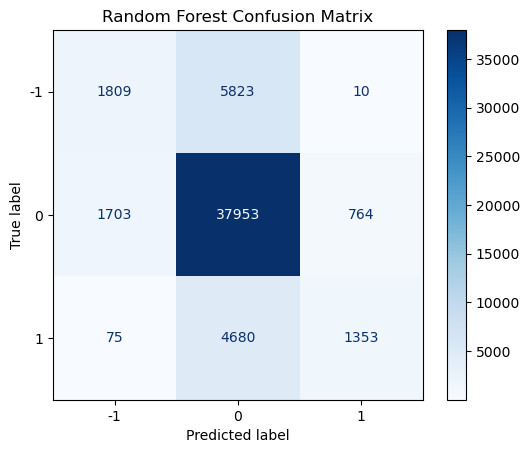

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Train Random Forest with class weights to focus on 1 and -1
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight={0: 1, 1: 3, -1: 3},  # increase importance of 1 and -1
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluation metrics
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 0, 1])
disp.plot(cmap="Blues", values_format="d")
plt.title("Random Forest Confusion Matrix")
plt.show()


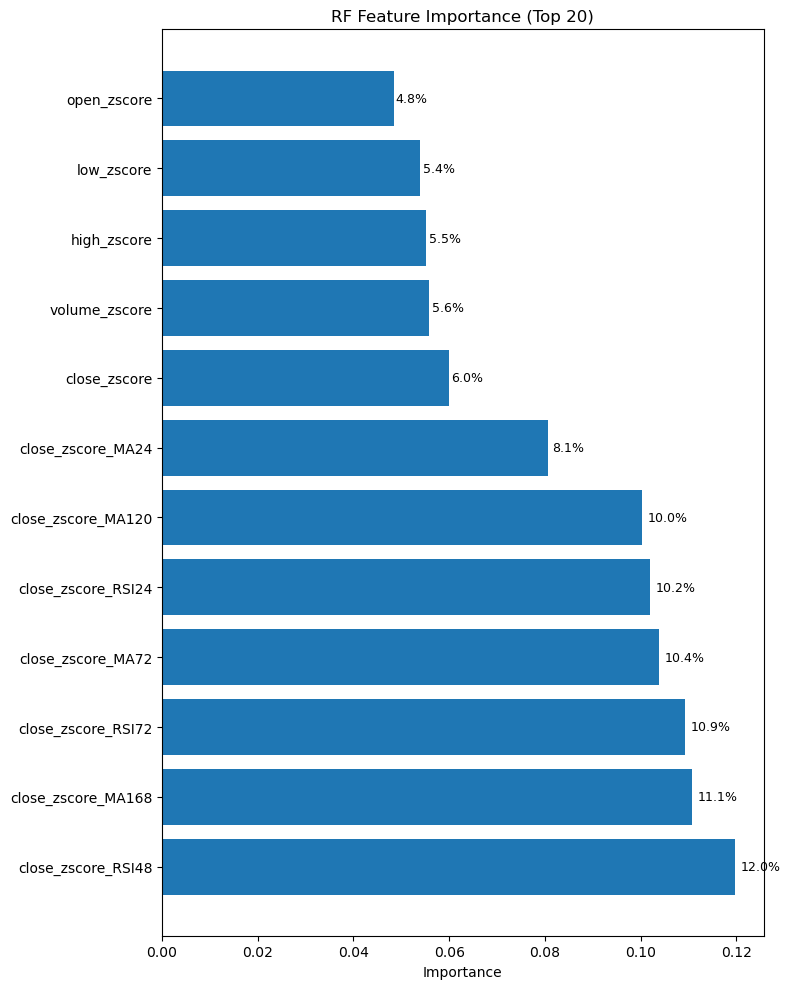

In [ ]:
def plot_feature_importance(model, feature_names, top_n=20, title="Feature Importance"):
    """
    Plot top-N feature importances for models exposing `feature_importances_`.

    Parameters
    ----------
    model : fitted estimator
        Must have attribute `feature_importances_`.
    feature_names : list-like
        Names of features in the same order used to fit the model (e.g., X.columns).
    top_n : int
        How many top features to display.
    title : str
        Plot title.
    """
    if not hasattr(model, "feature_importances_"):
        raise AttributeError("Model has no `feature_importances_`. "
                             "Use permutation importance for non-tree models.")

    importances = np.asarray(model.feature_importances_)
    names = np.asarray(feature_names)

    # sort descending and keep top_n
    idx = np.argsort(importances)[::-1][:top_n]
    imp_top = importances[idx]
    names_top = names[idx]

    # normalize to percentage
    perc = 100 * imp_top / imp_top.sum() if imp_top.sum() > 0 else imp_top

    plt.figure(figsize=(8, 0.45 * top_n + 1))
    plt.barh(range(len(imp_top))[::-1], imp_top[::-1], align="center")
    plt.yticks(range(len(names_top))[::-1], names_top[::-1])
    plt.xlabel("Importance")
    plt.title(title)
    # optional value labels on the right (percentage)
    for y, v, p in zip(range(len(perc))[::-1], imp_top[::-1], perc[::-1]):
        plt.text(v * 1.01, y, f"{p:.1f}%", va="center", fontsize=9)
    plt.tight_layout()
    plt.show()
plot_feature_importance(rf, X.columns, top_n=20, title="RF Feature Importance (Top 20)")


In [ ]:
probs = rf.predict_proba(X_test)
df_pred = X_test.copy()
df_pred["prob_down"] = probs[:, 0]
df_pred["prob_neutral"] = probs[:, 1]
df_pred["prob_up"] = probs[:, 2]
df_pred["true_target"] = y_test.values
df_pred["trend_signal"] = df_pred["prob_up"] 
df_pred = df_pred.merge(df[["coin", "date"]], left_index=True, right_index=True)
df_pred[["date", "coin", "prob_down", "prob_neutral", "prob_up", "true_target", "trend_signal"]].head()

,date,coin,prob_down,prob_neutral,prob_up,true_target,trend_signal
222187,2025-08-16 03:00:00,TAOUSDT,0.19000,0.80500,0.00500,-1.00000,0.00500
222188,2025-08-16 04:00:00,TAOUSDT,0.24000,0.73000,0.03000,-1.00000,0.03000
222189,2025-08-16 05:00:00,TAOUSDT,0.24000,0.74500,0.01500,-1.00000,0.01500
222190,2025-08-16 06:00:00,TAOUSDT,0.38000,0.61500,0.00500,-1.00000,0.00500
222191,2025-08-16 07:00:00,TAOUSDT,0.16500,0.83000,0.00500,-1.00000,0.00500


In [ ]:
import hvplot.pandas  # ensures interactive plotting
import holoviews as hv

def plot_coin_trend_signal_interactive(df, coin, date_col="date"):
    """
    Interactive hvPlot of close_zscore and trend_signal for a specific coin,
    with a vertical line following the mouse (crosshair).
    """
    data = df[df["coin"] == coin].copy()
    data[date_col] = pd.to_datetime(data[date_col], errors="coerce")

    close_plot = data.hvplot.line(
        x=date_col,
        y="close_zscore",
        color="blue",
        ylabel="Close Z-score",
        label="Close Z-score",
        width=1000,
        height=650,
        tools=["hover", "crosshair"],  # enables vertical hover line
    )

    signal_plot = data.hvplot.line(
        x=date_col,
        y="trend_signal",
        color="orange",
        ylabel="Trend Signal",
        label="Trend Signal",
        width=900,
        height=450,
        yaxis="right",
        tools=["hover", "crosshair"],
    )

    return (close_plot * signal_plot).opts(
        title=f"{coin} — Close Z-score vs Trend Signal",
        legend_position="top_left"
    )
plot_coin_trend_signal_interactive(df_pred, "TAOUSDT")


:Overlay
   .Curve.Close_Z_hyphen_minus_score :Curve   [date]   (close_zscore)
   .Curve.Trend_Signal               :Curve   [date]   (trend_signal)